In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#pip install geopandas matplotlib


C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_25336\1321153634.py:5: DtypeWarning: Columns (22,56,58,86,93,117,144,146,148,150,159,164,169,171,178,192,193,205,214,215,241,293,297) have mixed types. Specify dtype option on import or set low_memory=False.
  data_500k=pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/data_500k.csv')


In [ ]:
surveydata = pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/surveydata.csv')
data_500k=pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/data_500k.csv')


In [ ]:
#Replace blanks and spaces with NaN
surveydata.replace(r'^\s*$', np.nan, regex=True, inplace=True)
data_500k.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Gender, Ethnicity, Income, Education Distributions

In [13]:
#consolidate values
data_500k['SEX'] = data_500k['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})
surveydata['SEX'] = surveydata['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})


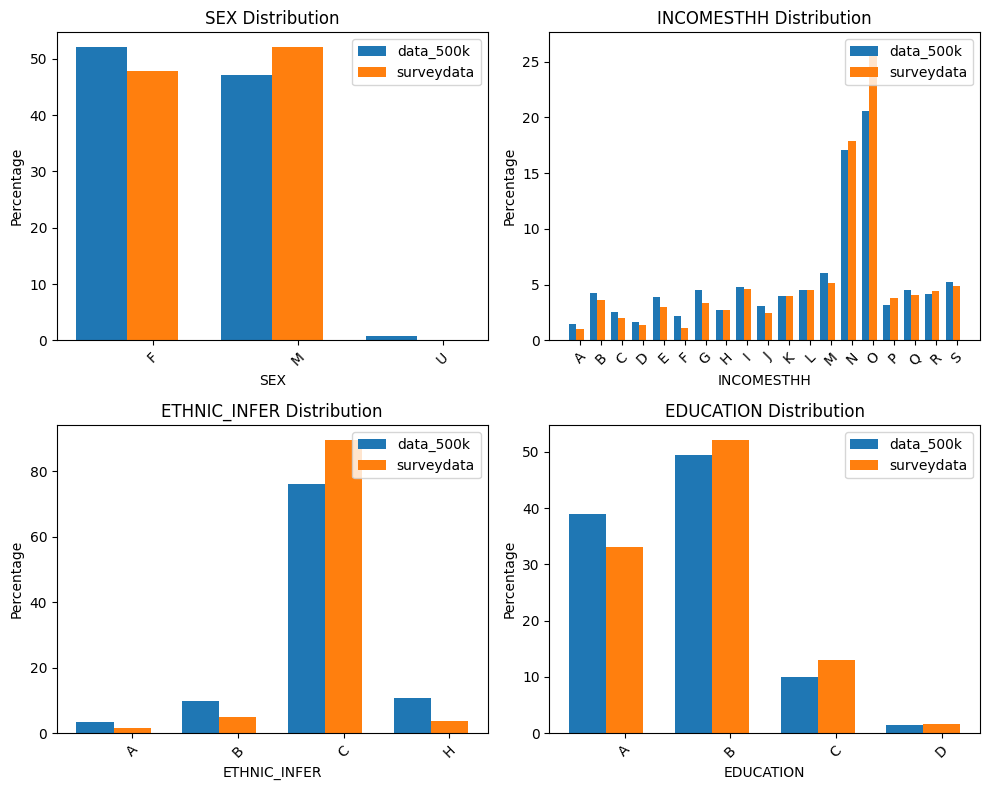

In [44]:

def plot_side_by_side_bars(ax, data1, data2, title):
    barWidth = 0.35
    r1 = np.arange(len(data1))
    r2 = [x + barWidth for x in r1]

    ax.bar(r1, data1, width=barWidth, label='data_500k')
    ax.bar(r2, data2, width=barWidth, label='surveydata')

    ax.set_xlabel(title)
    ax.set_ylabel('Percentage')
    ax.set_xticks([r + barWidth for r in range(len(data1))])
    ax.set_xticklabels(data1.index, rotation=45)
    ax.legend(loc='upper right')
    ax.set_title(f'{title} Distribution')

fields = ['SEX', 'INCOMESTHH', 'ETHNIC_INFER', 'EDUCATION']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for idx, field in enumerate(fields):
    data_500k_percentage = data_500k[field].value_counts(normalize=True) * 100
    surveydata_percentage = surveydata[field].value_counts(normalize=True) * 100

    for category in data_500k_percentage.index:
        if category not in surveydata_percentage:
            surveydata_percentage[category] = 0

    for category in surveydata_percentage.index:
        if category not in data_500k_percentage:
            data_500k_percentage[category] = 0

    # Sorting index to ensure the order of bars matches for both datasets
    data_500k_percentage = data_500k_percentage.sort_index()
    surveydata_percentage = surveydata_percentage.sort_index()

    row = idx // 2
    col = idx % 2
    plot_side_by_side_bars(axs[row, col], data_500k_percentage, surveydata_percentage, field)

plt.tight_layout()
plt.show()




In [45]:
fig.savefig('image1.png', dpi=300, bbox_inches='tight')

# AGE COMPARISON

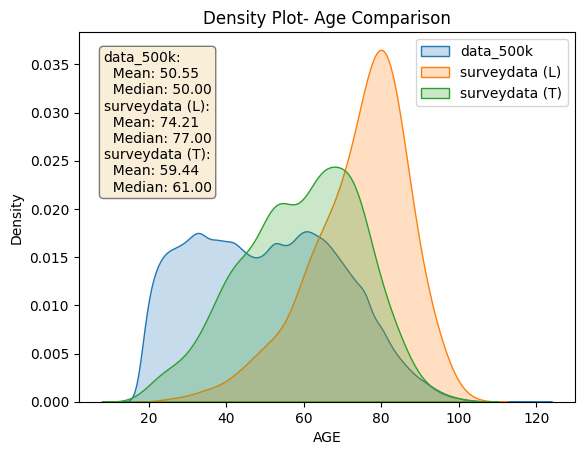

In [72]:

# Compute mean and median for each group
mean_age_data_500k = data_500k['AGE'].mean()
median_age_data_500k = data_500k['AGE'].median()

mean_age_surveydata_L = surveydata[surveydata['SURVEY_TYPE'] == 'L']['AGE'].mean()
median_age_surveydata_L = surveydata[surveydata['SURVEY_TYPE'] == 'L']['AGE'].median()

mean_age_surveydata_T = surveydata[surveydata['SURVEY_TYPE'] == 'T']['AGE'].mean()
median_age_surveydata_T = surveydata[surveydata['SURVEY_TYPE'] == 'T']['AGE'].median()

# Plotting KDE for AGE in data_500k
ax = sns.kdeplot(data_500k['AGE'], label='data_500k', fill=True)

# Plotting KDE for AGE in surveydata where SURVEY_TYPE is L (landline live call)
sns.kdeplot(surveydata[surveydata['SURVEY_TYPE'] == 'L']['AGE'], label='surveydata (L)', fill=True)

# Plotting KDE for AGE in surveydata where SURVEY_TYPE is T (text message)
sns.kdeplot(surveydata[surveydata['SURVEY_TYPE'] == 'T']['AGE'], label='surveydata (T)', fill=True)

# Adding labels, title, and legend
plt.title('Density Plot- Age Comparison')
plt.xlabel('AGE')
plt.ylabel('Density')
plt.legend()

# Display the mean and median values 
textstr = f"data_500k:\n  Mean: {mean_age_data_500k:.2f}\n  Median: {median_age_data_500k:.2f}\n"
textstr += f"surveydata (L):\n  Mean: {mean_age_surveydata_L:.2f}\n  Median: {median_age_surveydata_L:.2f}\n"
textstr += f"surveydata (T):\n  Mean: {mean_age_surveydata_T:.2f}\n  Median: {median_age_surveydata_T:.2f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.savefig('age_density.png', dpi=300, bbox_inches='tight')
plt.show()


# Missing Values comparison ( > 10 % difference)

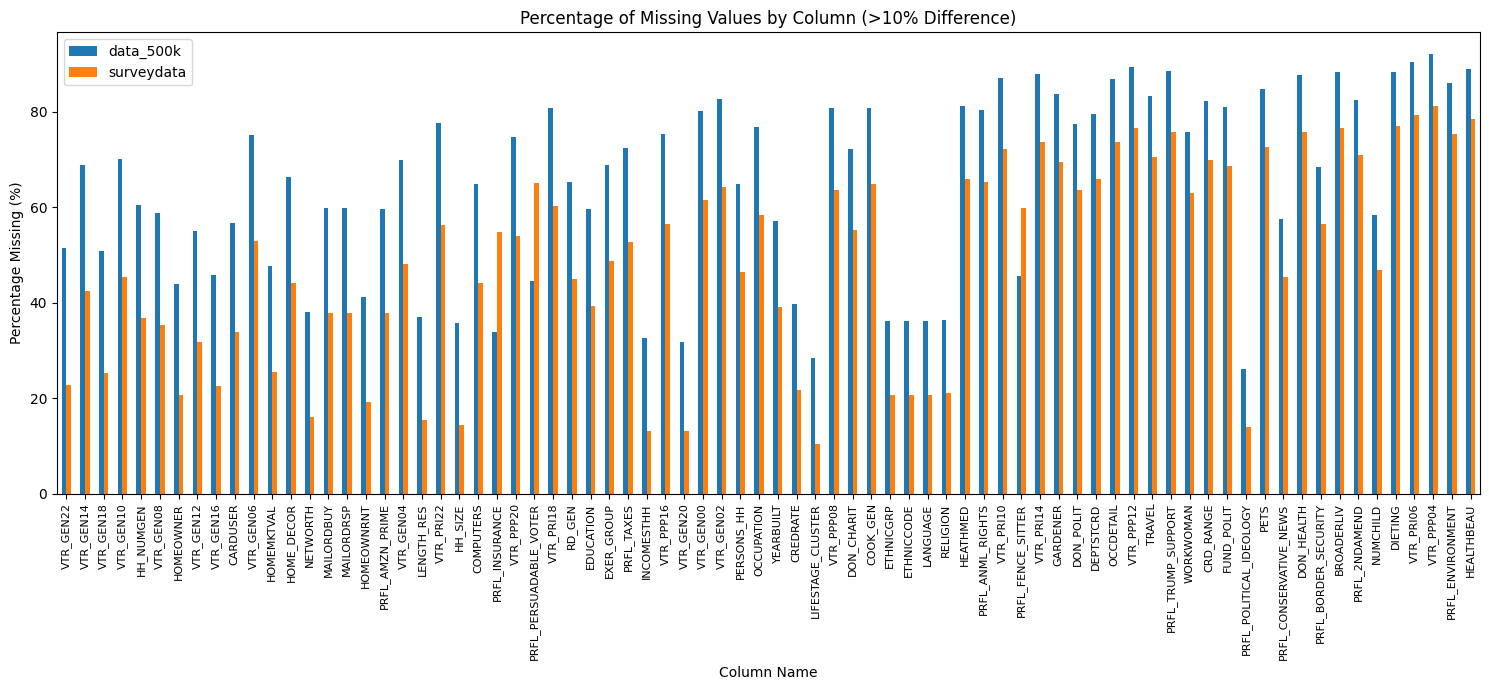

In [85]:

# Calculate the percentage of missing values in each column for both datasets
surveydata_missing_percent = surveydata.isnull().mean() * 100
data_500k_missing_percent = data_500k.isnull().mean() * 100

# Calculate the difference in missing value percentages between the two datasets
difference = (surveydata_missing_percent - data_500k_missing_percent).abs()

# Filter columns where the difference is greater than 10%
significant_diff_cols = difference[difference > 10].index

# Create a DataFrame including only significant difference columns
missing_df = pd.DataFrame({'surveydata': surveydata_missing_percent.loc[significant_diff_cols],
                           'data_500k': data_500k_missing_percent.loc[significant_diff_cols]})


missing_df['difference'] = abs(missing_df['data_500k'] - missing_df['surveydata'])

# Filtering columns with more than 10% difference in missing values
missing_df = missing_df[missing_df['difference'] > 10]

# Sorting the DataFrame 
missing_df = missing_df.sort_values(by='difference', ascending=False).reset_index()

#Plot
ax = missing_df.plot(x='index', y=['data_500k', 'surveydata'], kind='bar', figsize=(15, 7))
ax.set_xlabel("Column Name")  # Setting the x-axis label to "Column Name"
ax.set_ylabel('Percentage Missing (%)')
ax.set_title('Percentage of Missing Values by Column (>10% Difference)')
plt.xticks(rotation=90, fontsize=8)  # reduce font size 
plt.tight_layout()

# Save
plt.savefig('significant_missing_values_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


# Geographic Distribution Comparison

In [40]:
# Ensure the ZIP code columns are strings
data_500k['ZIP'] = data_500k['ZIP'].astype(str)
surveydata['ZIP'] = surveydata['ZIP'].astype(str)

# Pad ZIP codes with leading zeroes if they are less than 5 characters long
data_500k['ZIP'] = data_500k['ZIP'].apply(lambda x: x.zfill(5))
surveydata['ZIP'] = surveydata['ZIP'].apply(lambda x: x.zfill(5))

In [ ]:
# Read the local file
zip_shapes  = gpd.read_file("us_zcta.geojson")
#this file consolidated from state files located here: https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON

In [35]:
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_25336\425974234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_25336\3389613865.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_25336\3389613865.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


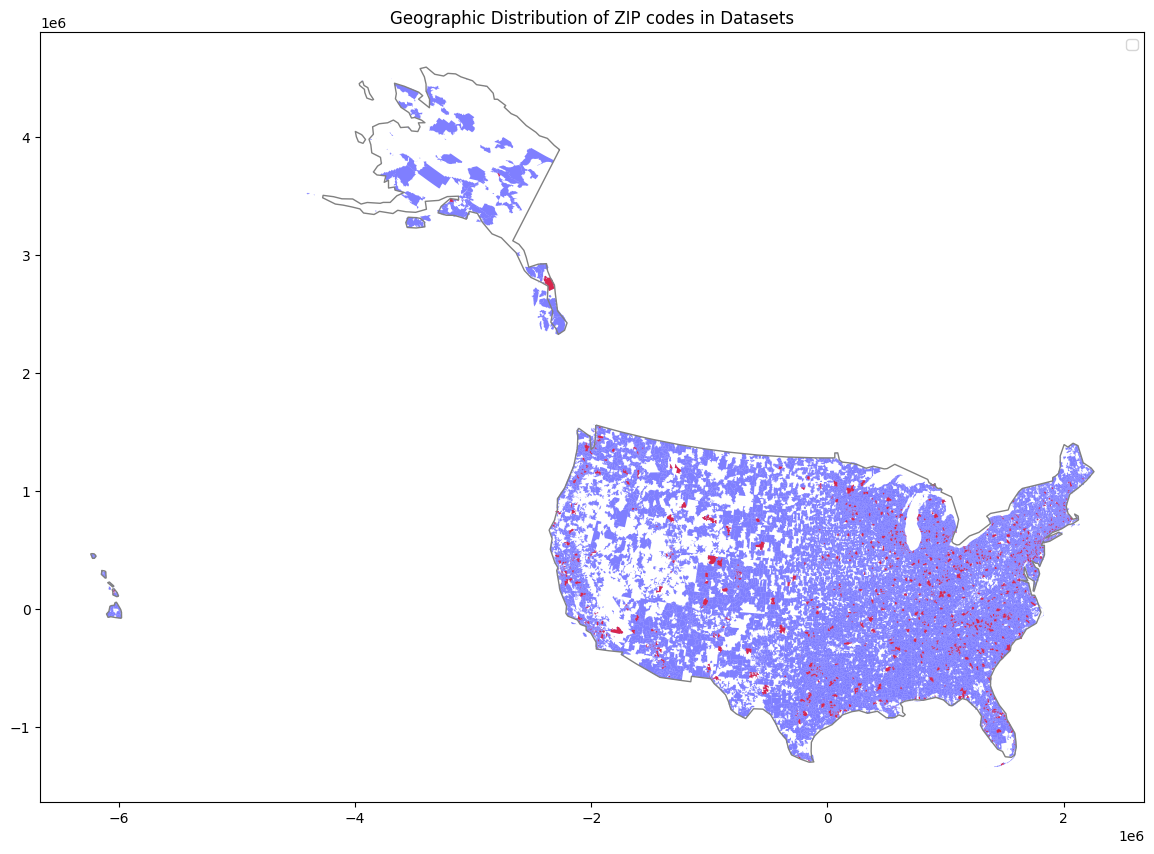

In [69]:

# Load the ZIP shapes and US boundaries

usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = usa[usa['name'] == "United States of America"]

# Set Albers Equal Area Conic projection for the US
albers_projection = {
    "proj": "aea",
    "lat_1": 29.5,
    "lat_2": 45.5,
    "lon_0": -96,
    "lat_0": 37.5
}
usa = usa.to_crs(crs=albers_projection)
zip_shapes = zip_shapes.to_crs(crs=albers_projection)

# Filter for ZIP codes in our datasets
zip_data_500k = zip_shapes[zip_shapes['ZCTA5CE10'].isin(data_500k['ZIP'].astype(str))]
zip_surveydata = zip_shapes[zip_shapes['ZCTA5CE10'].isin(surveydata['ZIP'].astype(str))]

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

usa.boundary.plot(ax=ax, linewidth=1, color='gray')
zip_data_500k.plot(ax=ax, color='blue', alpha=0.5, label='data_500k')
#zip_surveydata.plot(ax=ax, color='red', alpha=0.5, label='surveydata')
zip_surveydata.plot(ax=ax, color='#FF0000', linewidth=2, alpha=0.7, label='surveydata')
ax.set_title('Geographic Distribution of ZIP codes in Datasets')
ax.legend()
plt.show()


In [70]:
fig.savefig('geographic_distribution.png', dpi=300, bbox_inches='tight')

# Vote Count Comparison

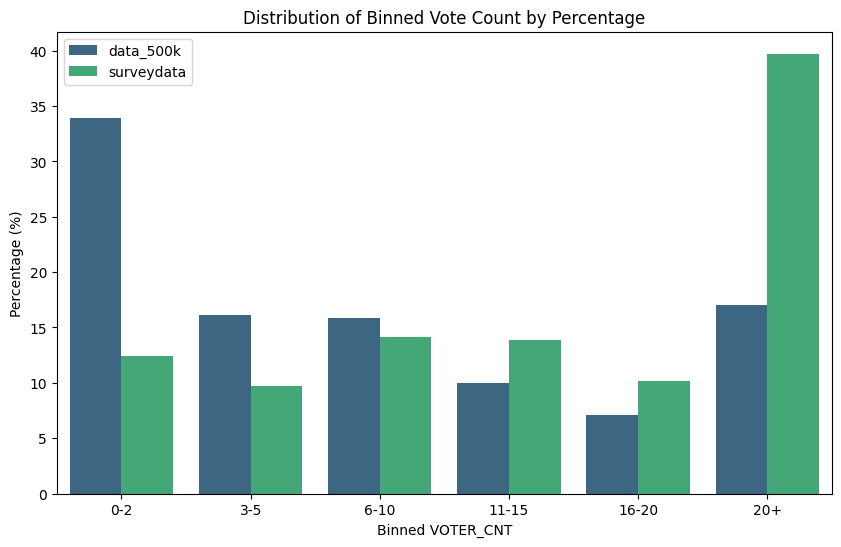

In [60]:

data_500k['VOTER_CNT'] = pd.to_numeric(data_500k['VOTER_CNT'], errors='coerce')
surveydata['VOTER_CNT'] = pd.to_numeric(surveydata['VOTER_CNT'], errors='coerce')

# Define the bins
bins = [-1, 2, 5, 10, 15, 20, float('inf')]
labels = ['0-2', '3-5', '6-10', '11-15', '16-20', '20+']

# Bin the data
data_500k['VOTER_CNT_BIN'] = pd.cut(data_500k['VOTER_CNT'], bins=bins, labels=labels)
surveydata['VOTER_CNT_BIN'] = pd.cut(surveydata['VOTER_CNT'], bins=bins, labels=labels)

# Combine the datasets for easier plotting
combined_data = pd.concat([
    data_500k.assign(dataset='data_500k'),
    surveydata.assign(dataset='surveydata')
])

# Calculate the percentage for each bin and dataset
grouped = combined_data.groupby(['dataset', 'VOTER_CNT_BIN']).size().unstack().T
grouped_percentage = grouped.div(grouped.sum()).T.mul(100)

plt.figure(figsize=(10, 6))

sns.barplot(data=grouped_percentage.reset_index().melt(id_vars='dataset'), 
            x='VOTER_CNT_BIN', 
            y='value', 
            hue='dataset', 
            palette='viridis')

# Setting the title and labels
plt.title('Distribution of Binned Vote Count by Percentage')
plt.xlabel('Binned VOTER_CNT')
plt.ylabel('Percentage (%)')
plt.legend()
plt.savefig('Vote_Cnt.png', dpi=300, bbox_inches='tight')
plt.show()





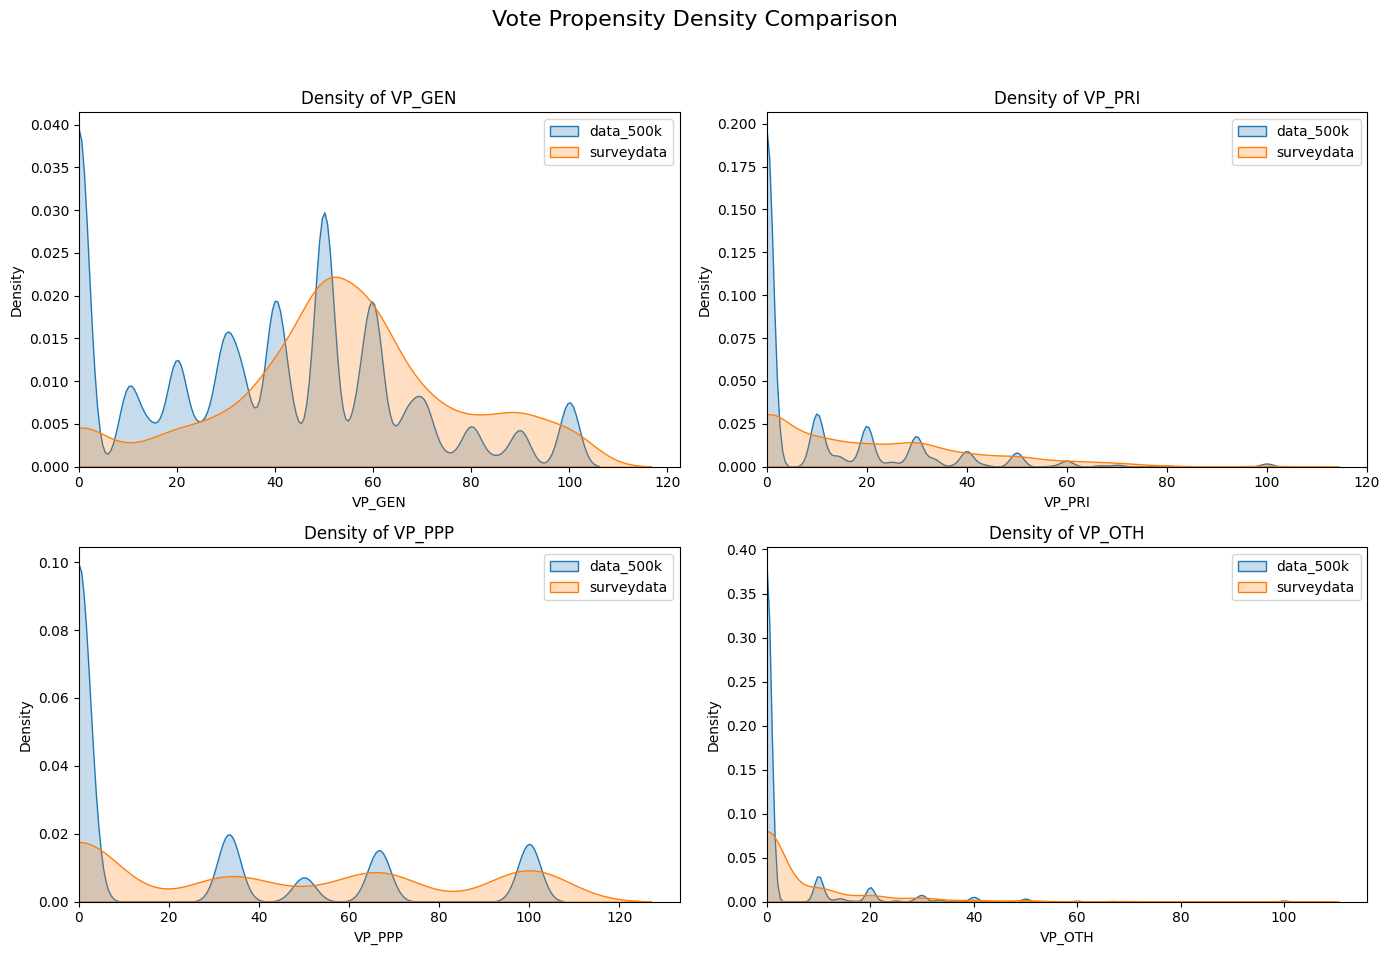

In [55]:

columns = ['VP_GEN', 'VP_PRI', 'VP_PPP', 'VP_OTH']
for col in columns:
    data_500k[col] = pd.to_numeric(data_500k[col], errors='coerce')
    surveydata[col] = pd.to_numeric(surveydata[col], errors='coerce')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the axes array to loop over it easily

# Plot on each axis
for ax, col in zip(axes, columns):
    sns.kdeplot(data_500k[col], fill=True, label='data_500k', ax=ax, clip=(0, None))
    sns.kdeplot(surveydata[col], fill=True, label='surveydata', ax=ax, clip=(0, None))
    ax.set_title(f'Density of {col}')
    ax.set_xlabel(col)
    ax.set_xlim(left=0)  # Set the x limit to 0
    ax.legend()


fig.suptitle('Vote Propensity Density Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to prevent overlap
plt.show()


# Party Code Comparison

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_25336\572361052.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(f'{int(val)}%' for val in ax.get_yticks())


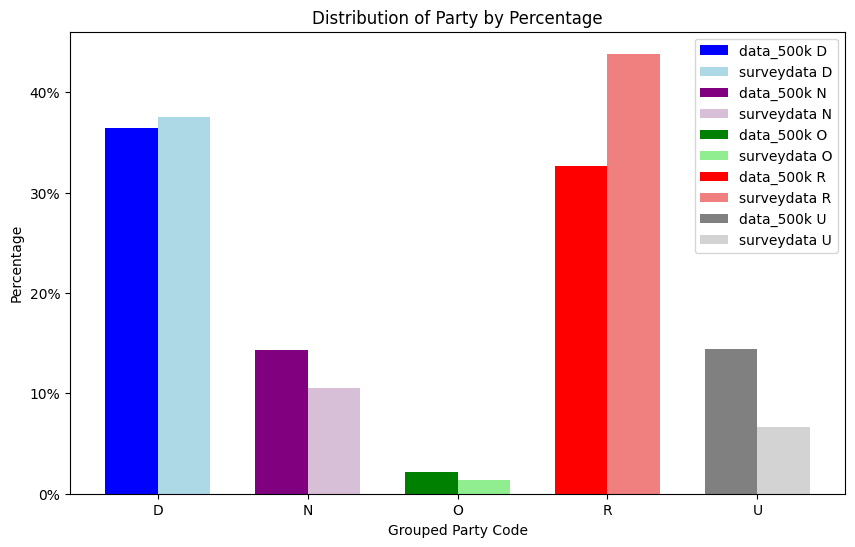

In [66]:

# Mapping the PARTY_CODE to new groups
party_code_mapping = {
    'R': 'R', 'S': 'R',
    'D': 'D', 'E': 'D',
    'N': 'N', 'U': 'U'
}

# If the party code is not in the mapping, assign 'O'
data_500k['GROUPED_PARTY'] = data_500k['PARTY_CODE'].map(party_code_mapping).fillna('O')
surveydata['GROUPED_PARTY'] = surveydata['PARTY_CODE'].map(party_code_mapping).fillna('O')

# Calculate the percentages for each group and dataset
data_500k_counts = data_500k['GROUPED_PARTY'].value_counts(normalize=True) * 100
surveydata_counts = surveydata['GROUPED_PARTY'].value_counts(normalize=True) * 100

# Combine the percentages into a single DataFrame for easier plotting
combined_counts = pd.DataFrame({
    'data_500k': data_500k_counts,
    'surveydata': surveydata_counts
}).fillna(0).reset_index().rename(columns={'index': 'GROUPED_PARTY'})

# Define the colors to use
colors = {
    'D': ['blue', 'lightblue'],
    'R': ['red', 'lightcoral'],
    'U': ['gray', 'lightgray'],
    'N': ['purple', 'thistle'],
    'O': ['green', 'lightgreen']
}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(combined_counts))

for i, row in combined_counts.iterrows():
    ax.bar(index[i], row['data_500k'], bar_width, label=f"data_500k {row['GROUPED_PARTY']}", color=colors[row['GROUPED_PARTY']][0])
    ax.bar(index[i] + bar_width, row['surveydata'], bar_width, label=f"surveydata {row['GROUPED_PARTY']}", color=colors[row['GROUPED_PARTY']][1])

ax.set_title('Distribution of Party by Percentage')
ax.set_xlabel('Grouped Party Code')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_counts['GROUPED_PARTY'])
ax.set_ylabel('Percentage')
ax.set_yticklabels(f'{int(val)}%' for val in ax.get_yticks())
ax.legend()

plt.savefig('Party_Code.png', dpi=300, bbox_inches='tight')
plt.show()
